<a href="https://colab.research.google.com/github/vas59/audio_python/blob/master/audio_research_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt


In [3]:
from imutils import paths
from keras.preprocessing.image import img_to_array
import random

Using TensorFlow backend.


In [2]:
!rm -rf audio_dataset
!git clone https://github.com/vas59/audio_dataset.git

Cloning into 'audio_dataset'...
remote: Enumerating objects: 65009, done.
remote: Total 65009 (delta 0), reused 0 (delta 0), pack-reused 65009
Receiving objects: 100% (65009/65009), 525.78 MiB | 23.93 MiB/s, done.
Resolving deltas: 100% (199/199), done.
Checking out files: 100% (64986/64986), done.


In [0]:
imagePaths = sorted(list(paths.list_images("audio_dataset/images_out")))


In [0]:
random.seed(42)
random.shuffle(imagePaths)

In [0]:
data = []
for imagePath in imagePaths:
    image = cv2.imread(imagePath, 1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (64, 64))/255.0
    data.append(image)

data = np.array(data)

In [0]:

# for i in data:
q = np.array([w.mean() for w in data]  )

In [8]:
q

array([0.11285424, 0.12516468, 0.06752164, ..., 0.12528244, 0.16223863,
       0.00860811])

In [0]:
import os
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)
labels = np.array(labels)

In [9]:
labels2 = labels[q > 0.002]
data2 = data[q > 0.002]
data2.shape

(50707, 64, 64)

In [0]:
data = data2
labels = labels2

In [12]:
q.shape

(50818,)

In [0]:
from keras.layers import Conv2D, Conv2DTranspose, Flatten, Input, Dense, Reshape
from keras.layers.advanced_activations import LeakyReLU, PReLU

from keras import Model

In [0]:
#auto decoder
input_ = Input((64, 64, 1)) 

x = Conv2D(filters=4, kernel_size=2, strides=2, activation='relu',padding='same')(input_) 
x = Conv2D(filters=6, kernel_size=2, strides=2, activation='relu',padding='same')(x)
x = Conv2D(filters=8,kernel_size=2, strides=2, activation='relu',padding='same')(x) 
flat = Flatten()(x)
latent = Dense(128,activation='relu')(flat)


reshape = Reshape((-1,8,8)) 
dense = Dense(512,activation='relu')
conv_2t_1 = Conv2DTranspose(filters=8, kernel_size=2, strides=2, activation='relu',padding='same') 
conv_2t_2 = Conv2DTranspose(filters=6, kernel_size=2, strides=2, activation='relu',padding='same') 
conv_2t_3 = Conv2DTranspose(filters=1, kernel_size=2, strides=2, activation='relu',padding='same') 
 

x = dense(latent)
x = reshape(x)
x = conv_2t_1(x)
x = conv_2t_2(x)
decoded = conv_2t_3(x) 

autoencoder = Model(input_, decoded)
encoder = Model(input_, latent)

decoder_input = Input((128,))
x_ = dense(decoder_input)
x_ = reshape(x_)
x_ = conv_2t_1(x_)
x_ = conv_2t_2(x_)
decoded_ = conv_2t_3(x_) 
decoder = Model(decoder_input, decoded_)

In [108]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 4)         20        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 6)         102       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 8)           200       
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 512)               66048     
__________

In [0]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [0]:
data = np.expand_dims(data, -1)

In [21]:
data.shape

(50707, 64, 64, 1)

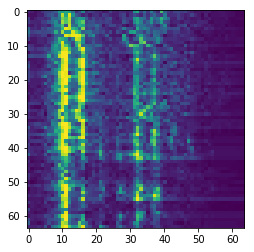

In [79]:
plt.imshow(np.squeeze(data[30]))

In [0]:
from sklearn.model_selection import train_test_split
(X_train, X_test, y_train, y_test) = train_test_split(data,
	labels, test_size=0.1, random_state=42)

In [13]:
autoencoder.fit(x = data, y = data, batch_size=128, epochs=37) #10+27

NameError: ignored

In [0]:
pred = encoder.predict(np.expand_dims(data[6000],axis=0))


In [0]:
pred_x = encoder.predict(data)

In [0]:
encoder.save("encoder_model_12000_out2.h5")
# encoder.save_weights("encoder.h5")

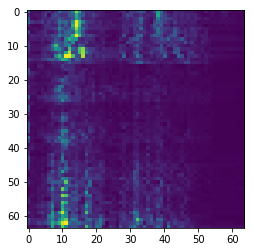

In [104]:
plt.imshow(np.squeeze(X_train[6000]))

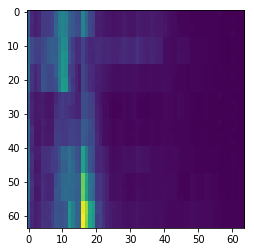

In [96]:
plt.imshow(np.squeeze(decoder.predict(pred)[0]))

In [98]:
pred_x[6000]

array([0.9000809 , 0.5899577 , 0.9239757 , 0.        , 0.9613411 ,
       1.1918973 , 0.13646331, 0.87489974, 0.8561525 , 0.52350074,
       0.07635103, 0.9902548 , 0.27210426, 0.77985704, 0.73188764,
       0.        , 0.23114622, 0.48274264, 0.61760175, 0.69122386,
       0.47524688, 0.67193747, 1.0241005 , 0.80520034, 0.        ,
       0.6595739 , 1.4699875 , 1.2345351 , 0.26645258, 0.37882942,
       0.8206509 , 0.9478471 , 0.2192364 , 0.        , 0.707946  ,
       1.33761   , 1.3951272 , 0.48411644, 1.3002911 , 0.9299097 ,
       1.4451736 , 1.0785714 , 0.82623523, 0.7405474 , 1.0465233 ,
       0.        , 0.03120595, 0.36437574, 0.        , 0.81822944,
       0.6782667 , 0.29132846, 0.14306056, 0.14450777, 0.39805794,
       1.0083182 , 1.5202479 , 0.49873775, 0.9857839 , 0.45726183,
       0.        , 0.        , 0.9079135 , 1.6884384 , 0.62509525,
       0.3775706 , 0.10655623, 0.7528955 , 0.45158556, 0.        ,
       0.6692924 , 0.3556566 , 0.77688813, 0.29162323, 0.97891

In [36]:
!pip install catboost

In [0]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

#     try:
#         del classifier # this is from global space - change this as you need
#     except:
#         pass

#     print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))

In [0]:
reset_keras()

In [0]:
import catboost

In [0]:
clf = catboost.CatBoostClassifier(task_type='GPU', max_depth=7, iterations=1500)

In [16]:
from keras.models import load_model
mm = load_model("/content/encoder_model_12000_out2.h5")

W0725 20:22:24.475303 140272290011008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 20:22:24.498274 140272290011008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 20:22:24.568053 140272290011008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0725 20:22:24.568999 140272290011008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0725 20:22:24.571205 140272290011008 depre

In [0]:
X_train_p = mm.predict(X_train)
X_test_p = mm.predict(X_test)

(64, 64, 1)


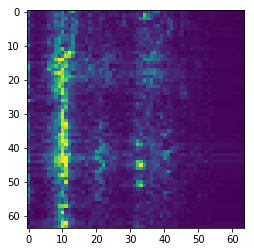

In [18]:
# data = np.expand_dims(data, -1)
plt.imshow(np.squeeze(X_train[0]))
print(X_train[0].shape)
# test_iiimg = np.array(X_train[0][:, :64])
# print(test_iiimg.shape)
# a = np.array([1,2,3,4,5])
# a = )
# print(np.expand_dims(X_train[0][0][0], 2))
test_img = np.array([i[0] for i in X_train[0][0]])
# print(test_img)


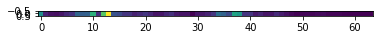

In [19]:
plt.imshow(np.expand_dims(test_img, axis=0))

In [0]:
aas = [19, 40, 13, 124, 77, 46, 45, 3, 15, 60, 61, 76, 91, 99, 113]
aas = [124, 77, 46, 45, 3, 15, 60, 61, 76, 91, 99, 113]
aas = [46, 45, 3, 15, 60, 61, 76, 91, 99, 113]
aas = []
df_train = pd.DataFrame(X_train_p).drop(aas, axis=1)
df_test = pd.DataFrame(X_test_p).drop(aas, axis=1)

# df_train2 = pd.DataFrame([np.array([i[0] for i in X_train[g][0]]) for g in range(X_train.shape[0])])
# df_test2 = pd.DataFrame([np.array([i[0] for i in X_test[g][0]]) for g in range(X_test.shape[0])])
# df_train2.columns = ["raw_" + str(i) for i in range(64)]
# df_test2.columns = ["raw_" + str(i) for i in range(64)]

# df_train = pd.concat([df_train, df_train2], axis=1)
# df_test = pd.concat([df_test, df_test2], axis=1)

In [39]:
df_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.164390,0.337083,0.519620,0.0,0.068507,0.265895,0.685372,0.241731,0.580784,0.506888,0.598368,0.498116,0.300631,0.297656,0.374910,0.0,0.107444,0.336780,0.500090,0.223469,0.150320,0.374189,0.152168,0.273778,0.098544,0.363420,0.590142,0.728496,0.203003,0.269541,0.234938,0.281170,0.244702,0.381618,1.042933,0.827056,0.748323,0.730462,0.157666,0.457092,...,0.109725,0.183261,0.284850,0.0,0.317434,0.237195,0.177281,0.155503,0.355120,0.618840,0.216368,0.0,0.679985,0.423393,0.040503,0.282307,1.415978,0.232769,0.807985,0.159287,0.342706,0.582985,0.486751,0.337432,0.436342,0.0,0.431411,0.373377,0.133021,0.488821,0.225037,0.518089,0.197805,0.654216,0.502694,0.586259,0.246227,0.759587,0.217764,0.195075
1,0.237331,0.232589,0.571408,0.0,0.200807,0.359434,0.465251,0.303728,0.417367,0.644594,0.257819,0.227488,0.381010,0.200546,0.688233,0.0,0.269155,0.348934,0.245378,0.291142,0.270694,0.325462,0.236152,0.399517,0.748317,0.217738,0.627429,0.628333,0.296690,0.197956,0.201317,0.340633,0.291927,0.231656,1.012843,0.983528,0.723361,0.830870,0.444615,0.188996,...,0.244048,0.302417,0.628286,0.0,0.137484,0.306711,0.212247,0.138661,0.544542,0.562538,0.123590,0.0,0.217701,0.550652,0.000000,0.149372,0.969824,0.292467,1.136352,0.206947,0.273191,0.691976,0.516766,0.253147,0.374400,0.0,0.565665,0.344050,0.200784,0.297267,0.196249,0.527660,0.449327,0.419163,0.243993,0.361335,0.350334,0.754639,0.148435,0.194259
2,0.152616,0.329870,0.539769,0.0,0.118322,0.338444,0.782066,0.355047,0.610442,0.366321,0.590145,0.471184,0.157531,0.236101,0.283989,0.0,0.142985,0.276451,0.578094,0.347488,0.190691,0.324596,0.278406,0.186390,0.245807,0.284212,0.594190,0.652031,0.189107,0.280796,0.258737,0.262054,0.202255,0.399775,0.947164,0.910010,0.703840,0.760905,0.170102,0.411115,...,0.062793,0.269923,0.523116,0.0,0.390524,0.263029,0.128143,0.162248,0.292516,0.771298,0.338936,0.0,0.638904,0.480521,0.016871,0.215509,1.328983,0.253164,0.811260,0.072994,0.337419,0.758000,0.402128,0.365517,0.406073,0.0,0.497025,0.377408,0.156503,0.454610,0.317952,0.503324,0.253360,0.707639,0.408628,0.528016,0.386122,0.723920,0.224425,0.190783
3,0.372358,0.232867,0.081693,0.0,0.417389,0.101990,0.289976,0.363098,0.826844,0.615453,0.595800,0.156474,0.246556,0.179806,0.435420,0.0,0.335861,0.110554,0.061829,0.179115,0.161141,0.288415,0.335350,0.430977,0.489219,0.296891,0.529540,0.652445,0.149911,0.144423,0.198702,0.365858,0.238183,0.261046,0.701533,1.091016,0.841774,0.670574,0.337526,0.246777,...,0.296292,0.565356,0.000000,0.0,0.337547,0.438419,0.292678,0.235790,0.608840,0.588887,0.490099,0.0,0.169719,0.649650,0.454183,0.116964,0.879025,0.259675,0.781603,0.191727,0.376736,0.797506,0.602954,0.313059,0.193499,0.0,0.531458,0.324583,0.213829,0.517203,0.083888,0.451916,0.328384,0.468651,0.000000,0.371692,0.575246,0.790592,0.395467,0.252940
4,2.036185,1.337819,2.320252,0.0,4.552681,2.387526,1.843889,0.635360,2.355589,1.834335,1.315271,1.798911,0.904597,0.681740,2.287458,0.0,1.328768,1.678304,1.681914,1.855152,0.333896,2.607466,1.444910,1.237188,0.000000,1.572491,2.361362,1.937874,1.397112,2.645730,2.446974,1.111151,1.560229,0.000000,1.357893,2.958038,2.803801,1.989715,3.338851,0.866226,...,1.662249,2.588947,1.337535,0.0,1.639479,0.935812,2.272725,1.396326,1.239209,0.975588,0.353246,0.0,1.802631,0.869569,0.000000,3.319738,1.118037,1.440621,4.110128,2.843010,2.047728,2.942430,2.169886,1.707471,1.507687,0.0,2.765943,2.278748,1.490234,1.163391,1.419945,1.657076,2.343354,2.893711,2.694656,2.772375,1.027394,2.294643,1.654359,1.179604
5,1.492210,3.036330,1.681900,0.0,3.811821,2.241767,2.353451,1.047268,3.000228,3.194654,0.975434,1.161763,1.347667,1.182526,1.687833,0.0,1.495949,0.029669,0.793645,1.982270,1.137941,3.280767,2.338191,3.433116,0.000000,1.928717,2.4452

In [36]:
clf.fit(df_train, y_train)

0:	learn: 1.3402902	total: 22.7ms	remaining: 34s
1:	learn: 1.2970544	total: 43.7ms	remaining: 32.7s
2:	learn: 1.2578320	total: 64.3ms	remaining: 32.1s
3:	learn: 1.2214412	total: 84.9ms	remaining: 31.7s
4:	learn: 1.1875412	total: 105ms	remaining: 31.5s
5:	learn: 1.1554702	total: 127ms	remaining: 31.6s
6:	learn: 1.1261359	total: 147ms	remaining: 31.3s
7:	learn: 1.0979112	total: 164ms	remaining: 30.6s
8:	learn: 1.0715272	total: 182ms	remaining: 30.1s
9:	learn: 1.0468734	total: 201ms	remaining: 29.9s
10:	learn: 1.0232696	total: 218ms	remaining: 29.5s
11:	learn: 1.0012338	total: 243ms	remaining: 30.2s
12:	learn: 0.9795470	total: 261ms	remaining: 29.8s
13:	learn: 0.9597175	total: 279ms	remaining: 29.6s
14:	learn: 0.9406464	total: 298ms	remaining: 29.5s
15:	learn: 0.9221600	total: 316ms	remaining: 29.3s
16:	learn: 0.9045978	total: 333ms	remaining: 29s
17:	learn: 0.8879696	total: 348ms	remaining: 28.7s
18:	learn: 0.8722595	total: 361ms	remaining: 28.1s
19:	learn: 0.8571852	total: 375ms	remaini

In [0]:
clf.save_model("catboost_decoder_12000_out2_6.catboost")

In [35]:
# clf.predict_proba(df_train[:, 50])# The_Show_Must_Go_On We_Are_The_Champions We_Will_Rock_You none

TypeError: ignored

In [40]:
# qwe
# qwe.load_model("catboost_decoder_12000_1.catboost")
from sklearn.metrics import accuracy_score

da_train = np.concatenate([X_train_p, [np.array([i[0] for i in X_train[g][0]]) for g in range(X_train.shape[0])]], axis=1)

print(accuracy_score(y_train, clf.predict(X_train_p)))
print(accuracy_score(y_test, clf.predict(df_test)))

1.0
1.0


In [0]:
# 0.9998466123236042
# 0.9992112009465589

# 0.9999123498992024
# 0.9992112009465589

# 0.9999780874748005
# 0.9990140011831986

# 1.0
# 0.9996056004732794

In [0]:


def displayImp(in_clf, x_in):
    if hasattr(in_clf, 'coef_'):
        df_importances = sorted(list(zip(x_in.columns, in_clf.coef_.ravel())), key=lambda tpl: tpl[1], reverse=True)
    else:
        df_importances= sorted(list(zip(x_in.columns, in_clf.feature_importances_.ravel())), key=lambda tpl: tpl[1], reverse=True)
    df_importances = pd.DataFrame(df_importances, columns=['feature', 'importance'])
    df_importances = df_importances.set_index('feature')
    df_importances = df_importances
    df_importances.plot(kind='bar', figsize=(15, 3))
    plt.show()
    display(df_importances)
    return df_importances



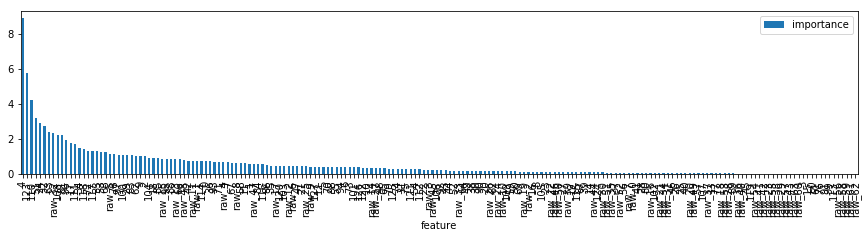

,importance
feature,
4,8.867362e+00
123,5.724108e+00
110,4.214133e+00
51,3.160476e+00
24,2.908199e+00
32,2.735385e+00
63,2.371979e+00
raw_32,2.324945e+00
108,2.234278e+00


In [31]:
df_importances = displayImp(clf, df_train)

In [50]:
list(df_importances.tail(15).index)

[19, 40, 13, 124, 77, 46, 45, 3, 15, 60, 61, 76, 91, 99, 113]